# MAP2220 - Fundamentos de Análise Numérica
## 2º Semestre de 2020 - Prof. Nelson Kuhl
## Exemplo com relação de recorrência em domínio discreto

Iremos demonstrar o uso de relações de recorrência com polinômios ortogonais mônicos em domínios discretos. O produto interno é da forma $\langle u, v\rangle = \sum_{i=1}^n \omega_iu(x_i)v(x_i)$. Os polinômios até grau $m$,
onde $m \le n-1$, são gerados por
$$
    p_{k+1}(x) = (x - \alpha_k)p_k(x) - \beta_kp_{k-1}(x), \quad 0 \le k \le m -1,
$$
com $p_{-1}(x) = 0$, $p_0(x) = 1$ e
$$
    \alpha_k = \frac{\langle xp_k,p_k\rangle}{\langle p_k, p_k\rangle}, \quad 0 \le k \le m-1, \quad
    \beta_k = \frac{\langle p_k, p_k\rangle}{\langle p_{k-1}, p_{k-1}\rangle}, \quad 1 \le k \le m-1.
$$
Como são necessários apenas os valores dos polinômios nos pontos $x_i$, $1 \le i \le n$, somente estes são calculados.

In [1]:
function monicos(m, xi, wi)
    #= Dados os pontos x1, ..., xn e respectivos pesos w1, ..., wn,
       o algoritmo "contrói" os m+1 (i.e, até grau m) primeiros
       polinômios ortogonais em relação ao produto interno discreto
       com peso. São retornados: os valores dos polinômios em uma
       matriz n x (m+1), onde a coluna j refere-se ao grau (j-1);
       as normas ao quadrado dos polinômios e os coeficientes da
       relação de recorrência. =#

    n = length(xi); # quantidade de pontos
    
    if m > n - 1
        print("O valor de m deve ser menor ou igual a $(n - 1)")
        return (nothing, nothing, nothing, nothing)
    end

    PK = zeros(n, m+1) # para os polinômios
    pkpk = zeros(m + 1); α = zeros(m); β = zeros(m) # para as normas e os coeficientes
    
    PK[:,1] = ones(n); pkpk[1] = sum(wi) # grau zero
    
    α[1] = sum(wi .* xi)/pkpk[1]; PK[:,2] = xi .- α[1]; pkpk[2] = sum(wi .* PK[:,2] .* PK[:,2]) # grau 1
    
    for k in 2:m # Graus 2 até m+1
        α[k] = sum(wi .* xi .* PK[:,k] .* PK[:,k])/pkpk[k]
        β[k] = pkpk[k]/pkpk[k-1]
        PK[:,k+1] = (xi .- α[k]) .* PK[:,k] - β[k] * PK[:,k-1]
        pkpk[k+1] = sum(wi .* PK[:,k+1] .* PK[:,k+1])
    end
    return (PK, pkpk, α, β)
end

monicos (generic function with 1 method)

Uma vez gerados estes polinômios (na verdade, os valores destes polinômios nos pontos da malha), podemos usá-los para aproximar uma função $f$, tabelada nos pontos da malha, por um polinômio de grau menor ou igual a $m$, pelo MMQ. A solução é $g(x) = \sum_{k=0}^m c_kp_k(x)$ com
$$
    c_k = \frac{\langle p_k, f\rangle}{\langle p_k, p_k\rangle} =
    \frac{\sum_{i=1}^n \omega_ip_k(x_i)f(x_i)}{\sum_{i=1}^n \omega_ip_k^2(x_i)}, \quad 0 \le k \le m.
$$
Note que para os cálculos dos coeficientes, **usamos somente** os valores dos polinômios nos pontos da tabela e as suas normas, que são calculados na função *monicos* acima. Se quisermos calcular o valor de $g(x)$ em um ponto $x$, pdemos fazê-lo sen conhecer as fórmulas explícitas dos $p_k(x)$, usando o algoritmo de Clenshaw. Tudo o que precisamos são os coeficientes $c_k$ e os valores de $\alpha_k$ e $\beta_k$, já calculados.

In [2]:
# Algoritmo de Clenshaw adaptado para a recursão dos polinômios mônicos
function clenshaw(x, c, alfa, beta)
    a = x .- alfa
    M = length(c)
    y = zeros(M)
    y[M] = c[M]; y[M-1] = c[M-1] + a[M-1]*y[M]
    for k in M-2:-1:1
        y[k] = c[k] + a[k]*y[k+1] - beta[k+1]*y[k+2]
    end
    return y[1]
end

clenshaw (generic function with 1 method)

### Exemplo
Para praticarmos os métodos acima, faremos alguns exemplos arbitrários.

In [3]:
using LinearAlgebra, Plots

In [4]:
# Pontos e pesos
x = collect(0.1:0.1:0.9)
w = ones(length(x)) # Pesos iguais a 1
[x'; w']

2×9 Array{Float64,2}:
 0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

In [5]:
# Construção da matriz dos polinômios, respectivas normas ao quadrado e coeficientes da recorrência
(MP, normp2, α, β) = monicos(4, x, w); # Grau menor ou igual a 4

In [6]:
MP # valores dos polinômios nos pontos; a coluna k é referente a p_{k-1}

9×5 Array{Float64,2}:
 1.0  -0.4   0.0933333  -0.0168        0.0024
 1.0  -0.3   0.0233333   0.0084       -0.0036
 1.0  -0.2  -0.0266667   0.0156       -0.00188571
 1.0  -0.1  -0.0566667   0.0108        0.00154286
 1.0   0.0  -0.0666667   7.40149e-18   0.00308571
 1.0   0.1  -0.0566667  -0.0108        0.00154286
 1.0   0.2  -0.0266667  -0.0156       -0.00188571
 1.0   0.3   0.0233333  -0.0084       -0.0036
 1.0   0.4   0.0933333   0.0168        0.0024

In [7]:
# Verificação aproximada da ortogonalidade
isapprox(MP'*(diagm(w)*MP), diagm(normp2))

true

In [8]:
[α'; β'] # Parâmetros da recorrência

2×4 Array{Float64,2}:
 0.5  0.5        0.5        0.5
 0.0  0.0666667  0.0513333  0.0462857

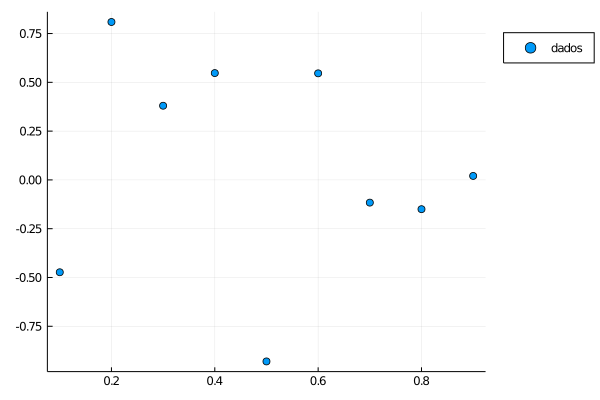

In [9]:
# f gerada aleatoriamente segundo a distribuição normal
f = randn(length(x))
scatter(x, f, label = "dados", legend = :outertopright)

In [10]:
# Cálculo dos coeficientes c_k
c = zeros(length(normp2))
for k in 1:length(normp2)
    c[k] = sum(w .* MP[:,k] .* f)/normp2[k]
end
c'

1×5 Adjoint{Float64,Array{Float64,1}}:
 0.0703584  -0.316237  -1.09978  16.9108  -87.3616

In [11]:
# Calculo de g em vários pontos para obter o seu gráfico
xx = collect(range(x[1], stop=x[end], step=0.01))
N = length(xx)
g = zeros(N)
for i in 1:N
    g[i] = clenshaw(xx[i], c, α, β)
end

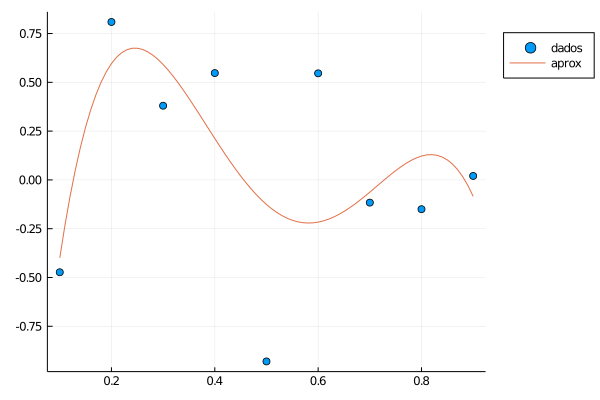

In [12]:
plot!(xx, g, label = "aprox")

In [13]:
# Agora usando pesos, apenas por curiosidade.
w = 1 ./ collect(1:length(x)) # w_i = 1/i

9-element Array{Float64,1}:
 1.0
 0.5
 0.3333333333333333
 0.25
 0.2
 0.16666666666666666
 0.14285714285714285
 0.125
 0.1111111111111111

In [14]:
# Construção da matriz dos polinômios, respectivas normas ao quadrado e coeficientes da recorrência
(MP, normp2, α, β) = monicos(4, x, w); # Grau menor ou igual a 4

In [15]:
MP # valores dos polinômios nos pontos; a coluna k é referente a p_{k-1}; observe a diferença

9×5 Array{Float64,2}:
 1.0  -0.218137    0.039964    -0.00604243   0.000746506
 1.0  -0.118137   -0.0166937    0.0110894   -0.00277325
 1.0  -0.0181372  -0.0533513    0.0125264   -0.000350327
 1.0   0.0818628  -0.070009     0.00426862   0.00260582
 1.0   0.181863   -0.0666667   -0.00768398   0.00308571
 1.0   0.281863   -0.0433243   -0.0173314    0.000479897
 1.0   0.381863    1.79972e-5  -0.0186736   -0.0034211
 1.0   0.481863    0.0633603   -0.00571061  -0.00442675
 1.0   0.581863    0.146703     0.0275576    0.00405349

In [16]:
# Verificação aproximada da ortogonalidade
isapprox(MP'*(diagm(w)*MP), diagm(normp2))

true

In [17]:
[α'; β'] # Parâmetros da recorrência; observe a diferença

2×4 Array{Float64,2}:
 0.318137  0.548439   0.518164   0.516837
 0.0       0.0578573  0.0489099  0.044345

In [18]:
# Cálculo dos coeficientes c_k; observe a diferença
c = zeros(length(normp2))
for k in 1:length(normp2)
    c[k] = sum(w .* MP[:,k] .* f)/normp2[k]
end
c'

1×5 Adjoint{Float64,Array{Float64,1}}:
 0.0235932  0.257146  -4.29747  27.7433  -110.062

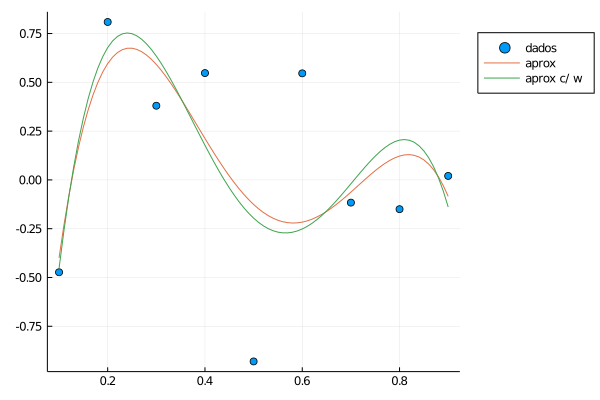

In [19]:
# Cálculo da nova aproximação nos pontos xx anteriores e respectivo gráfico
gw = zeros(N)
for i in 1:N
    gw[i] = clenshaw(xx[i], c, α, β)
end
plot!(xx, gw, label = "aprox c/ w")